In [1]:
# reference from Gromacs tutorial 'Lysozyme in Water'
import biotite
import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.structure.io.xtc as xtc
import numpy as np
import matplotlib.pyplot as plt

# Put here the path of the downloaded files
templ_file_path = "./data/lysozyme_md.pdb"
traj_file_path  = "./data/lysozyme_md.xtc"

# Gromacs does not set the element symbol in its PDB files,
# but Biotite guesses the element names from the atom names,
# emitting a warning
template = strucio.load_structure(templ_file_path)
# The structure still has water and ions, that are not needed for our
# calculations, we are only interested in the protein itself
# These are removed for the sake of computational speed using a boolean
# mask
protein_mask = struc.filter_amino_acids(template)
template = template[protein_mask]
# We could have loaded the trajectory also with
# 'strucio.load_structure()', but in this case we only want to load
# those coordinates that belong to the already selected atoms of the
# template structure.
# Hence, we use the 'XTCFile' class directly to load the trajectory
# This gives us the additional option that allows us to select the
# coordinates belonging to the amino acids.
xtc_file = xtc.XTCFile.read(traj_file_path, atom_i=np.where(protein_mask)[0]) # np.where只提供condition参数时等价于np.asarray(protein_mask).nonzero()
trajectory = xtc_file.get_structure(template)
# Get simulation time for plotting purposes
time = xtc_file.get_time()

Since the MD simulation used periodic boundaries, the protein might be segmented over the box boundary. For further analysis we need to reassemble the protein chain into a whole molecule, without periodic boundaries. in Gromacs we could have used gmx trjconv for this, but this problem can be handled in Biotite, too.

In [21]:
trajectory = struc.remove_pbc(trajectory)

Now our trajectory is ready for some analysis! At first we want to see if the simulation converged. For this purpose we take the RMSD of a frame compared to the initial model as measure. In order to calculate the RMSD we must superimpose all models onto a reference, in this case we also choose the initial structure.

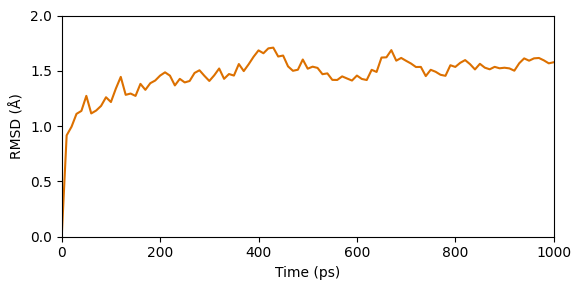

In [28]:
trajectory, transform = struc.superimpose(trajectory[0], trajectory) #按照第1帧来对齐所有结构
rmsd = struc.rmsd(trajectory[0], trajectory)

figure = plt.figure(figsize=(6,3))
ax = figure.add_subplot(111)
ax.plot(time, rmsd, color=biotite.colors["dimorange"])
ax.set_xlim(time[0], time[-1])
ax.set_ylim(0, 2)
ax.set_xlabel("Time (ps)")
ax.set_ylabel("RMSD (Å)")
figure.tight_layout()

As we can see the simulation seems to converge already early in the simulation. After a about 200 ps the RMSD stays in a range of approx. 1 - 2 Å.

In order to futher evaluate the unfolding of our enzyme in the course of simulation, we calculate and plot the radius of gyration (a measure for the protein radius).

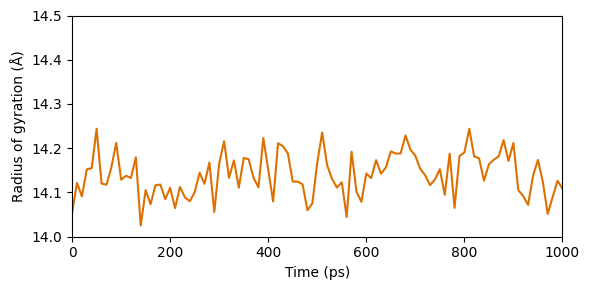

In [33]:
radius = struc.gyration_radius(trajectory)

figure = plt.figure(figsize=(6,3))
ax = figure.add_subplot(111)
ax.plot(time, radius, color=biotite.colors["dimorange"])
ax.set_xlim(time[0], time[-1])
ax.set_ylim(14.0, 14.5)
ax.set_xlabel("Time (ps)")
ax.set_ylabel("Radius of gyration (Å)")
figure.tight_layout()

From this perspective, the protein seems really stable. The radius does merely fluctuate in a range of approximately 0.3 Å during the entire simulation.

Let’s have a look at single amino acids: Which residues fluctuate most? For answering this question we calculate the RMSF (Root mean square fluctuation). It is similar to the RMSD, but instead of averaging over the atoms and looking at each time step, we average over the time and look at each residue. Usually the average model is taken as reference (compared to the starting model for RMSD).

Since side chain atoms fluctuate quite a lot, they are not suitable for evaluation of the residue flexibility. Therefore, we consider only CA atoms.

RMSF反应的是MD过程中，每个原子（CA代表残基）的平均变化：1.先求每个CA的平均位置当成reference 2.再进行root mean saquare sum

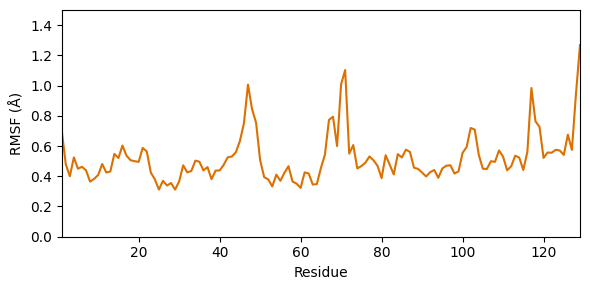

In [40]:
# In all models, mask the CA atoms
ca_trajectory = trajectory[:, trajectory.atom_name == "CA"]
rmsf = struc.rmsf(struc.average(ca_trajectory), ca_trajectory)

figure = plt.figure(figsize=(6,3))
ax = figure.add_subplot(111)
res_count = struc.get_residue_count(trajectory)
ax.plot(np.arange(1, res_count+1), rmsf, color=biotite.colors["dimorange"])
ax.set_xlim(1, res_count)
ax.set_ylim(0, 1.5)
ax.set_xlabel("Residue")
ax.set_ylabel("RMSF (Å)")
figure.tight_layout()


plt.show()